Agreement with GPT-4 for "Does this prompt require a clarifying question?"

0.6153846153846154


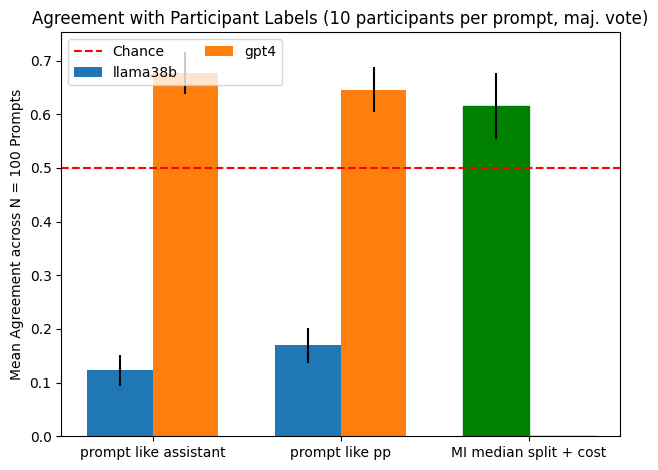

In [129]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load labels
participant = json.load(open('data/labels/philpp_labels.json'))[:100]
philipp = [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]

# llama
llama38b = json.load(open('data/labels/llama_labels_v3.json'))[:100]
llama38b_reversed = json.load(open('data/labels/llama_labels_v3_reversed.json'))[:100]
llama38b_roleplay = json.load(open('data/labels/llama_labels_v3_roleplay.json'))[:100]
llama38b_roleplay_reversed = json.load(open('data/labels/llama_labels_v3_reversed_roleplay.json'))[:100]

# gpt4 (renaming files)
gpt4 = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100.json'))['label'][:100]
gpt4_reversed = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100_reversed.json'))['label'][:100]
gpt4_roleplay = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100_roleplay.json'))['label'][:100]
gpt4_roleplay_reversed = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100_reversed_roleplay.json'))['label'][:100]

# llama38b-mi
llama38b_mi = json.load(open('data/labels/llama_mi_labels_human_assistant_instruct_5k.json'))[:100]

# Calculate agreements
def calculate_agreement(model_labels, participant=philipp):
    return [int(i == j) for i, j in zip(model_labels, philipp) if j == 0]

agreement_philipp_llama38b = calculate_agreement(llama38b)
agreement_philipp_llama38b_reversed = calculate_agreement(llama38b_reversed)
agreement_philipp_llama38b_roleplay = calculate_agreement(llama38b_roleplay)
agreement_philipp_llama38b_roleplay_reversed = calculate_agreement(llama38b_roleplay_reversed)

agreement_philipp_gpt4 = calculate_agreement(gpt4)
agreement_philipp_gpt4_reversed = calculate_agreement(gpt4_reversed)
agreement_philipp_gpt4_roleplay = calculate_agreement(gpt4_roleplay)
agreement_philipp_gpt4_roleplay_reversed = calculate_agreement(gpt4_roleplay_reversed)
mi = [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
agreement_philipp_llama38b_mi = calculate_agreement(mi)
print(np.mean(agreement_philipp_llama38b_mi))
# mi = [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
# agreement_gpt4_llama38b_mi = calculate_agreement(mi, philipp=gpt4)
# print(np.mean(agreement_gpt4_llama38b_mi))

# Calculate mean agreements
mean_agreement_llama_original = np.mean([np.mean(agreement_philipp_llama38b), np.mean(agreement_philipp_llama38b_reversed)])
mean_agreement_llama_roleplay = np.mean([np.mean(agreement_philipp_llama38b_roleplay), np.mean(agreement_philipp_llama38b_roleplay_reversed)])
# print([np.mean(agreement_philipp_llama38b), np.mean(agreement_philipp_llama38b_reversed)])
# print([np.mean(agreement_philipp_llama38b_roleplay), np.mean(agreement_philipp_llama38b_roleplay_reversed)])

mean_agreement_gpt4_original = np.mean([np.mean(agreement_philipp_gpt4), np.mean(agreement_philipp_gpt4_reversed)])
# print([np.mean(agreement_philipp_gpt4), np.mean(agreement_philipp_gpt4_reversed)])
mean_agreement_gpt4_roleplay = np.mean([np.mean(agreement_philipp_gpt4_roleplay), np.mean(agreement_philipp_gpt4_roleplay_reversed)])
# print([np.mean(agreement_philipp_gpt4_roleplay), np.mean(agreement_philipp_gpt4_roleplay_reversed)])


def bootstrap_se(data, n_bootstrap=1000):
    means = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(np.mean(sample))
    return np.std(means)

n = len(philipp)
se_llama_original = bootstrap_se(agreement_philipp_llama38b + agreement_philipp_llama38b_reversed)
se_llama_roleplay = bootstrap_se(agreement_philipp_llama38b_roleplay + agreement_philipp_llama38b_roleplay_reversed)

se_gpt4_original = bootstrap_se(agreement_philipp_gpt4 + agreement_philipp_gpt4_reversed)
se_gpt4_roleplay = bootstrap_se(agreement_philipp_gpt4_roleplay + agreement_philipp_gpt4_roleplay_reversed)

se_llama_mi = bootstrap_se(agreement_philipp_llama38b_mi)





# Create lists for plotting
mean_agreement_llama = [
    mean_agreement_llama_original,
    mean_agreement_llama_roleplay,
    np.mean(agreement_philipp_llama38b_mi)
]

mean_agreement_gpt4 = [
    mean_agreement_gpt4_original,
    mean_agreement_gpt4_roleplay,
    0
]

errors_llama = [se_llama_original, se_llama_roleplay, se_llama_mi]
errors_gpt4 = [se_gpt4_original, se_gpt4_roleplay, 0]

# Plotting the agreements
labels = ['prompt like assistant', 'prompt like pp', 'MI median split + cost']
x = np.arange(len(labels))

fig, ax = plt.subplots()
bar_width = 0.35

rects1 = ax.bar(x - bar_width/2, mean_agreement_llama, bar_width, yerr=errors_llama, label='llama38b')
rects2 = ax.bar(x + bar_width/2, mean_agreement_gpt4, bar_width, yerr=errors_gpt4,label='gpt4')

# Color the MI bars green
rects1[2].set_color('green')
rects2[2].set_color('green')

ax.axhline(y=0.5, color='r', linestyle='--', label='Chance')

# ax.set_xlabel('Model Variants')
ax.set_ylabel('Mean Agreement across N = 100 Prompts')
ax.set_title('Agreement with Participant Labels (10 participants per prompt, maj. vote)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper left")

plt.tight_layout()
plt.show()

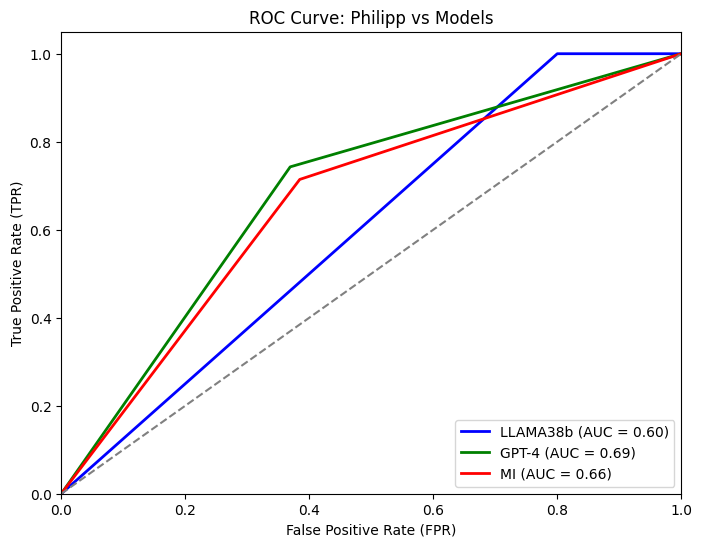

In [127]:
import json
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Load participant labels (assuming these are binary labels for each prompt)
philipp = [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]

# Load model labels
llama38b = json.load(open('data/labels/llama_labels_v3.json'))[:100]
llama38b_reversed = json.load(open('data/labels/llama_labels_v3_reversed.json'))[:100]
llama38b_roleplay = json.load(open('data/labels/llama_labels_v3_roleplay.json'))[:100]
llama38b_roleplay_reversed = json.load(open('data/labels/llama_labels_v3_reversed_roleplay.json'))[:100]

gpt4 = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100.json'))['label'][:100]
gpt4_reversed = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100_reversed.json'))['label'][:100]
gpt4_roleplay = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100_roleplay.json'))['label'][:100]
gpt4_roleplay_reversed = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100_reversed_roleplay.json'))['label'][:100]

# Function to calculate agreement
def calculate_agreement(model_labels, participant=philipp):
    return [int(i == j) for i, j in zip(model_labels, participant)]

# Calculate agreements for LLAMA and GPT-4
agreement_philipp_llama38b = calculate_agreement(llama38b)
agreement_philipp_llama38b_reversed = calculate_agreement(llama38b_reversed)
agreement_philipp_llama38b_roleplay = calculate_agreement(llama38b_roleplay)
agreement_philipp_llama38b_roleplay_reversed = calculate_agreement(llama38b_roleplay_reversed)

agreement_philipp_gpt4 = calculate_agreement(gpt4)
agreement_philipp_gpt4_reversed = calculate_agreement(gpt4_reversed)
agreement_philipp_gpt4_roleplay = calculate_agreement(gpt4_roleplay)
agreement_philipp_gpt4_roleplay_reversed = calculate_agreement(gpt4_roleplay_reversed)

# Function to compute ROC curve and ROC AUC
def compute_roc_auc(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    return fpr, tpr, roc_auc

# Compute ROC curves for LLAMA and GPT-4 compared to Philipp
fpr_llama, tpr_llama, roc_auc_llama = compute_roc_auc(philipp, llama38b_roleplay_reversed)
fpr_gpt4, tpr_gpt4, roc_auc_gpt4 = compute_roc_auc(philipp, gpt4)
fpr_mi, tpr_mi, roc_auc_mi = compute_roc_auc(philipp, mi)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_llama, tpr_llama, color='blue', lw=2, label=f'LLAMA38b (AUC = {roc_auc_llama:.2f})')
plt.plot(fpr_gpt4, tpr_gpt4, color='green', lw=2, label=f'GPT-4 (AUC = {roc_auc_gpt4:.2f})')
plt.plot(fpr_mi, tpr_mi, color='red', lw=2, label=f'MI (AUC = {roc_auc_mi:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: Philipp vs Models')
plt.legend(loc="lower right")
plt.show()

# Additional computations or plots as needed


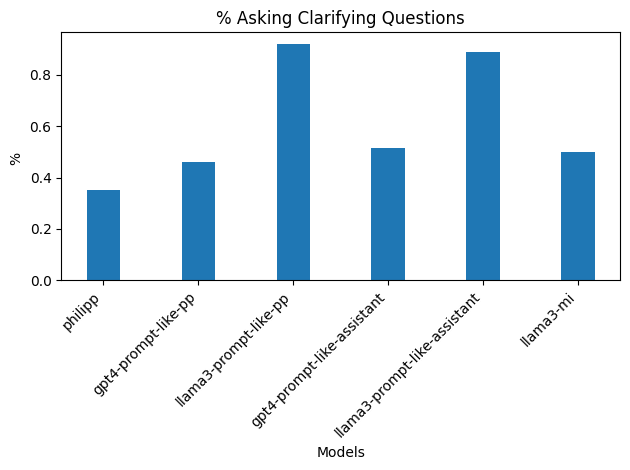

In [32]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load labels
philipp = json.load(open('data/labels/philpp_labels.json'))[:100]
philipp = [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


# llama
llama38b = json.load(open('data/labels/llama_labels_v3.json'))[:100]
llama38b_reversed = json.load(open('data/labels/llama_labels_v3_reversed.json'))[:100]
llama38b_roleplay = json.load(open('data/labels/llama_labels_v3_roleplay.json'))[:100]
llama38b_roleplay_reversed = json.load(open('data/labels/llama_labels_v3_reversed_roleplay.json'))[:100]

# gpt4 (renaming files)
gpt4 = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100.json'))['label'][:100]
gpt4_reversed = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100_reversed.json'))['label'][:100]
gpt4_roleplay = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100_roleplay.json'))['label'][:100]
gpt4_roleplay_reversed = json.load(open('data/labels/gpt4_labels_human_assistant_instruct_0_100_reversed_roleplay.json'))['label'][:100]

# llama38b-mi
llama38b_mi = [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
# Calculate means
mean_philipp = np.mean(philipp)

mean_llama38b = np.mean(llama38b)
mean_llama38b_reversed = np.mean(llama38b_reversed)
mean_llama38b_roleplay = np.mean(llama38b_roleplay)
mean_llama38b_roleplay_reversed = np.mean(llama38b_roleplay_reversed)

mean_gpt4 = np.mean(gpt4)
mean_gpt4_reversed = np.mean(gpt4_reversed)
mean_gpt4_roleplay = np.mean(gpt4_roleplay)
mean_gpt4_roleplay_reversed = np.mean(gpt4_roleplay_reversed)

mean_llama38b_mi = np.mean(llama38b_mi)

# Average across original and reversed
mean_llama38b_combined = np.mean([mean_llama38b, mean_llama38b_reversed])
mean_llama38b_roleplay_combined = np.mean([mean_llama38b_roleplay, mean_llama38b_roleplay_reversed])

mean_gpt4_combined = np.mean([mean_gpt4, mean_gpt4_reversed])
mean_gpt4_roleplay_combined = np.mean([mean_gpt4_roleplay, mean_gpt4_roleplay_reversed])

# Create lists for plotting
labels = ['philipp', 'gpt4-prompt-like-pp', 'llama3-prompt-like-pp', 'gpt4-prompt-like-assistant', 'llama3-prompt-like-assistant', 'llama3-mi']
means = [
    mean_philipp,
    mean_gpt4_combined,
    mean_llama38b_combined,
    mean_gpt4_roleplay_combined,
    mean_llama38b_roleplay_combined,
    mean_llama38b_mi
]


# Plotting the means
x = np.arange(len(labels))

fig, ax = plt.subplots()

rects = ax.bar(x, means, bar_width)

ax.set_xlabel('Models')
ax.set_ylabel('% ')
ax.set_title('% Asking Clarifying Questions')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()


44


/tmp/user/22820/ipykernel_2209876/1584194726.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(ncol=3, loc="upper left")


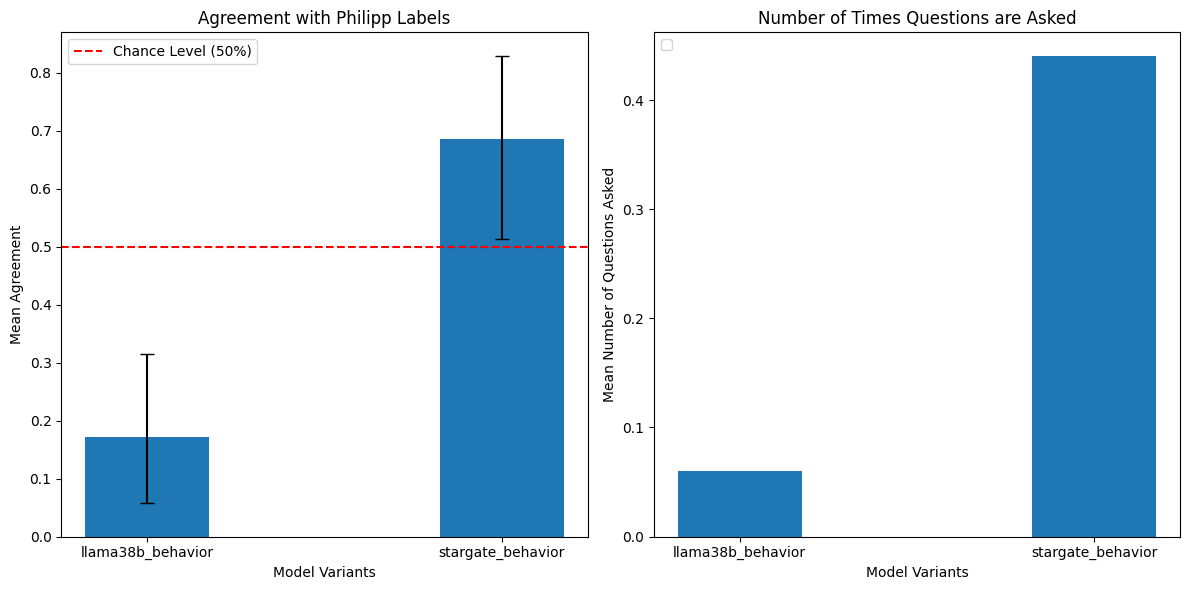

F1 Score with llama38b: 0.29
F1 Score with stargate: 0.61


In [97]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load labels
philipp = json.load(open('data/labels/philpp_labels.json'))[:100]
philipp = [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]

# llama38b_behavior and stargate_behavior
llama38b_behavior = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
stargate_behavior = [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]


print(stargate_behavior.count(1))
# Calculate agreements
def calculate_agreement(model_labels):
    return [int(i == j) for i, j in zip(model_labels, philipp) if j == 1]

agreement_philipp_llama38b_behavior = calculate_agreement(llama38b_behavior)
agreement_philipp_stargate_behavior = calculate_agreement(stargate_behavior)

# Calculate means
mean_llama38b_behavior = np.mean(agreement_philipp_llama38b_behavior)
mean_stargate_behavior = np.mean(agreement_philipp_stargate_behavior)

# Bootstrap confidence intervals
def bootstrap_ci(data, n_bootstrap=1000, ci_percentile=95):
    means = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(np.mean(sample))
    lower = np.percentile(means, (100-ci_percentile)/2)
    upper = np.percentile(means, 100-(100-ci_percentile)/2)
    return lower, upper

ci_llama38b_behavior = bootstrap_ci(agreement_philipp_llama38b_behavior)
ci_stargate_behavior = bootstrap_ci(agreement_philipp_stargate_behavior)

# Create lists for plotting
labels = ['llama38b_behavior', 'stargate_behavior']
means_agreement = [
    mean_llama38b_behavior,
    mean_stargate_behavior
]
ci_lower_agreement = [
    mean_llama38b_behavior - ci_llama38b_behavior[0],
    mean_stargate_behavior - ci_stargate_behavior[0]
]
ci_upper_agreement = [
    ci_llama38b_behavior[1] - mean_llama38b_behavior,
    ci_stargate_behavior[1] - mean_stargate_behavior
]

# Calculate the mean number of times questions are asked
mean_questions_llama38b_behavior = np.mean(llama38b_behavior)
mean_questions_stargate_behavior = np.mean(stargate_behavior)

means_questions = [
    mean_questions_llama38b_behavior,
    mean_questions_stargate_behavior
]

# Plotting the agreements with confidence intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

x = np.arange(len(labels))
bar_width = 0.35

# Left panel: Agreement with Philipp
rects1 = ax1.bar(x, means_agreement, bar_width, yerr=[ci_lower_agreement, ci_upper_agreement], capsize=5)
ax1.axhline(y=0.5, color='r', linestyle='--', label='Chance Level (50%)')
ax1.set_xlabel('Model Variants')
ax1.set_ylabel('Mean Agreement')
ax1.set_title('Agreement with Philipp Labels')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(ncol=3, loc="upper left")

# Right panel: Number of times questions are asked
rects2 = ax2.bar(x, means_questions, bar_width)

ax2.set_xlabel('Model Variants')
ax2.set_ylabel('Mean Number of Questions Asked')
ax2.set_title('Number of Times Questions are Asked')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend(ncol=3, loc="upper left")

plt.tight_layout()
plt.show()
from sklearn.metrics import f1_score
f1_llama38b = f1_score(philipp, llama38b_behavior, average='binary')
f1_stargate = f1_score(philipp, stargate_behavior, average='binary')

print(f"F1 Score with llama38b: {f1_llama38b:.2f}")
print(f"F1 Score with stargate: {f1_stargate:.2f}")

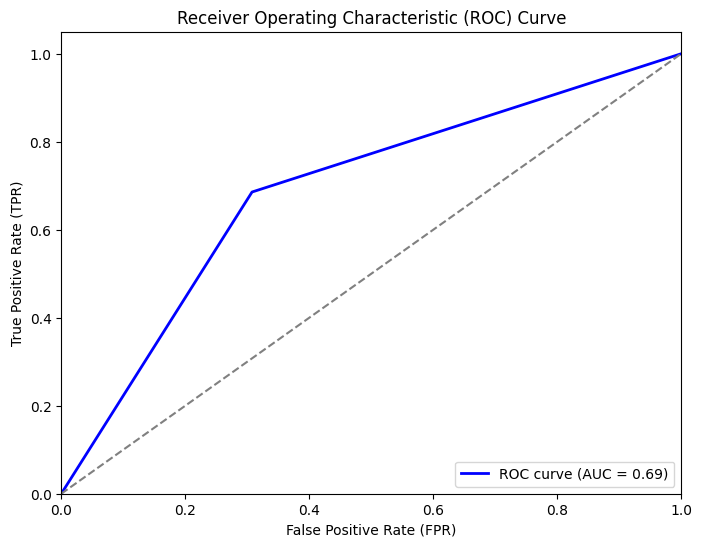

In [113]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Example predicted probabilities and true labels
y_true = [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]

# llama38b_behavior and stargate_behavior
# y_scores = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_scores = [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]



# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_true, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [76]:
gpt4_labels_human_assistant_instruct = json.load(open('data/labels/gpt4_labels_human_assistant_instruct.json'))['label']
agreement = [int(i == j) for i, j in zip(gpt4_labels_human_assistant_instruct, should_ask_questions)]
print(len(agreement))
np.mean(agreement)

1000


0.638

In [63]:
human_labels = []
prompts = json.load(open('data/human_assistant_instruct.json'))
for prompt in prompts[:100]:
    print(prompt)

    human_labels.append(int(input()))

I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.
What type of wine goes best with steak.
How do I know if this is a good investment.
Please provide me with some financial advice.
What kind of safety devices do I need to install in my house.


ValueError: invalid literal for int() with base 10: ''

In [12]:
import json

# Load the prompts
with open('data/human_assistant_instruct.json') as f:
    prompts = json.load(f)

human_labels = []

# Function to display and label prompts
def label_prompts(prompts):
    for i, prompt in enumerate(prompts[:100]):
        print(f"Prompt {i+1}: {prompt}")
        while True:
            try:
                label = input("Enter label (0 or 1): ")
                if label in ['0', '1']:
                    human_labels.append(int(label))
                    break
                else:
                    print("Invalid input. Please enter 0 or 1.")
            except ValueError:
                print("Invalid input. Please enter 0 or 1.")
    print("Labeling complete.")
    return human_labels

# Label the prompts
labels = label_prompts(prompts)

# Save the labels if needed
with open('labels.json', 'w') as f:
    json.dump(labels, f)


Prompt 1: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.


Prompt 2: What type of wine goes best with steak.
Prompt 3: How do I know if this is a good investment.
Prompt 4: Please provide me with some financial advice.
Invalid input. Please enter 0 or 1.
Prompt 5: What kind of safety devices do I need to install in my house.
Prompt 6: How do I interpret the results of my blood test.
Prompt 7: I'm having trouble finding the perfect job. What resources can help me.
Invalid input. Please enter 0 or 1.
Prompt 8: What does a roux look like.
Prompt 9: How to make money online.
Invalid input. Please enter 0 or 1.
Prompt 10: What are some job options for engineering majors.
Prompt 11: How does quantum computing work.
Prompt 12: Do you have any ideas for a fun date night.
Prompt 13: What music is popular in Brazil.
Invalid input. Please enter 0 or 1.
Prompt 14: How should I handle a disagreement with my boss.
Prompt 15: Where can I find a good quality used car nearby.
Invalid input. Please enter 0 or 1.
Prompt 16: How do I reset my phone password.
Prom

In [15]:
# print(labels)
# with open('philpp_labels.json', 'w') as f:
#     json.dump(labels, f, indent=4)

[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1]


In [24]:
agreement = [int(i == j) for i, j in zip(llama, labels)]
np.mean(agreement)

0.55

In [28]:
sum(gpt4), sum(labels), sum(llama)

(53, 49, 4)

In [30]:
gpt4 = json.load(open('data/gpt4_labels.json'))['label'][:100]
llama = json.load(open('llama_labels.json'))
philipp = json.load(open('philpp_labels.json'))
philipp = json.load(open('philpp_labels.json'))

In [31]:
philipp[:5], gpt4[:5], llama[:5]

([0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [0, 0, 0, 0, 0])

In [42]:
gpt4 = json.load(open('data/gpt4_labels.json'))['label'][:100]
llama = json.load(open('llama_labels.json'))
philipp = json.load(open('philpp_labels.json'))
philipp = json.load(open('philpp_labels.json'))

agreement_philipp_gpt4 = np.mean([i == j for i, j in zip(philipp, gpt4)])
print(agreement_philipp_gpt4)
agreement_philipp_llama = np.mean([i == j for i, j in zip(philipp, should_ask_questions)])
print(agreement_philipp_llama)
agreement_gpt4_llama = np.mean([i == j for i, j in zip(gpt4, should_ask_questions)])
print(agreement_gpt4_llama)

breakpoint()

0.8
0.65
0.67


In [1]:
import numpy as np

In [3]:
a = np.array([1, 2, 3, 3])
np.argmax(np.bincount(a))

3

In [4]:
import json
conversations = json.load(open('data/conversations_human_assistant_instruct.json'))

In [5]:
conversation_dict = {}
for prompt_id, user_id, prompt, attempt, question, response in zip(*conversations.values()):
    conversation_key = f"prompt_{prompt_id}_user_{user_id}_attempt_{attempt}"
    conversation_dict[conversation_key] = {"prompt": prompt, "question": question, "response": response}

In [1]:
messages = [{"role": "user", "content": "Hi how are you?"}, 
            {"role": "assistant", "content": "I am good how are you?"},
            {"role": "user", "content": "Thanks I am great! What are you up to?"},
            {"role": "assistant", "content": "Not much!"}]

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path="meta-llama/Meta-Llama-3-8B-Instruct",
    cache_dir="/scr/jphilipp/stargate/pretrained_models/Meta-Llama-3-8B-Instruct",
    model_max_length=2048
    )

tokenizer.pad_token, tokenizer.padding_side = tokenizer.eos_token, "right"

/scr/jphilipp/miniconda3/envs/stargate/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
import copy
import torch

def _tokenize_fn(
    messages,
    tokenizer,
    IGNORE_INDEX=-100,
):
    # tokenize messages 
    inputs, labels = {}, {}
    for turn, _ in enumerate(messages):
        tokenized = tokenizer.apply_chat_template(
                messages[turn:turn + 1],
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
                add_generation_prompt=False,
                tokenize=False,
            )

        print(tokenized)
    #     inputs[turn] = tokenized
    
    #     # labels (mask user turns which are every second; currently not using system messages)
    #     if turn % 2 == 0:
    #         labels[turn] = torch.tensor(IGNORE_INDEX, dtype=torch.long).repeat(tokenized.shape[0])
    #     else:
    #         labels[turn] = tokenized
    
    # input_ids = torch.cat([tokenized for tokenized in inputs.values()], dim=0)
    # labels = torch.cat([tokenized for tokenized in labels.values()], dim=0)
    
    # return dict(
    #     input_ids=input_ids,
    #     labels=labels,
    #     attention_mask=torch.ones_like(input_ids),
    # )
    

_tokenize_fn(messages=messages, tokenizer=tokenizer)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Hi how are you?<|eot_id|>
<|begin_of_text|><|start_header_id|>assistant<|end_header_id|>

I am good how are you?<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Thanks I am great! What are you up to?<|eot_id|>
<|begin_of_text|><|start_header_id|>assistant<|end_header_id|>

Not much!<|eot_id|>


In [3]:
output

{'input_ids': tensor([128000, 128006,    882, 128007,    271,  13347,   1268,    527,    499,
             30, 128009, 128000, 128006,  78191, 128007,    271,     40,   1097,
           1695,   1268,    527,    499,     30, 128009, 128000, 128006,    882,
         128007,    271,  12947,    358,   1097,   2294,      0,   3639,    527,
            499,    709,    311,     30, 128009, 128000, 128006,  78191, 128007,
            271,   2688,   1790,      0, 128009]),
 'labels': tensor([  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100, 128000, 128006,  78191, 128007,    271,     40,   1097,
           1695,   1268,    527,    499,     30, 128009,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100, 128000, 128006,  78191, 128007,
            271,   2688,   1790,      0, 128009]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [20]:
output['input_ids']

tensor([128000, 128006,    882, 128007,    271,  13347,   1268,    527,    499,
            30, 128009, 128006,  78191, 128007,    271,     40,   1097,   1695,
          1268,    527,    499,     30, 128009, 128006,    882, 128007,    271,
         12947,    358,   1097,   2294,      0,   3639,    527,    499,    709,
           311,     30, 128009, 128006,  78191, 128007,    271,   2688,   1790,
             0, 128009])

In [23]:
output['labels']

tensor([  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100, 128006,  78191, 128007,    271,     40,   1097,   1695,
          1268,    527,    499,     30, 128009,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100, 128006,  78191, 128007,    271,   2688,   1790,
             0, 128009])

In [26]:
tokenizer.decode([128006,  78191, 128007,    271,     40,   1097,   1695, 1268,    527,    499,     30, 128009])
tokenizer.decode([128006,  78191, 128007,    271,   2688,   1790, 0, 128009])

'<|start_header_id|>assistant<|end_header_id|>\n\nNot much!<|eot_id|>'

In [14]:
win_rates = json.load(open('data/win_rates_1e-5.json'))
resp = json.load(open('data/final_performance_m1.json'))
resp = [1 if "question" in v else 0 for v in resp.values()]
win_q = [w for w, r in zip(win_rates, resp) if r == 1]
win_nq = [w for w, r in zip(win_rates, resp) if r == 0]
(np.mean(win_q) + np.mean(win_nq))/2

0.5763620763620764

In [124]:
data = json.load(open("data/mutual_information/human_assistant_instruct_5k_users_0_1_4_17.json", "r"))
data = [datum["mutual_information"] for datum in data.values()][:100]
data = [1 if datum > 1 * np.median(data) else 0 for datum in data]
print(data)
# print(data.count(1))

[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]


In [120]:
data = json.load(open('data/original_prompts/human_assistant_instruct.json', 'r'))[100:200]

In [122]:
batch_0 = data[:50]
# batch_1 = data[50:]
len(batch_0)
batch_0 = [{"question_id": i + 100, "content": question} for i, question in enumerate(batch_0)]
# batch_1 = [{"question_id": i + 50, "content": question} for i, question in enumerate(batch_1)]
with open('batch_2.json', 'w') as f:
    json.dump(batch_0, f, indent=4)
# with open('batch_1.json', 'w') as f:
#     json.dump(batch_1, f, indent=4)